In [19]:
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
from tqdm import tqdm
from predict import *

# from HIST2ST_Baseline import *
# from HIST2ST_HGNN import *
from HIST2ST_HGNN_CSCC import *
# from HIST2ST_STNet import *

from dataset import ViT_HER2ST, ViT_SKIN
from scipy.stats import pearsonr,spearmanr
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

# Data Loading

In [20]:
name=[*[f'A{i}' for i in range(2,7)],*[f'B{i}' for i in range(1,7)],
      *[f'C{i}' for i in range(1,7)],*[f'D{i}' for i in range(1,7)],
      *[f'E{i}' for i in range(1,4)],*[f'F{i}' for i in range(1,4)],*[f'G{i}' for i in range(1,4)]]
patients = ['P2', 'P5', 'P9', 'P10']
reps = ['rep1', 'rep2', 'rep3']
skinname = []
for i in patients:
    for j in reps:
        skinname.append(i+'_ST_'+j)
device='cuda'
tag='5-7-2-8-4-16-32'
k,p,d1,d2,d3,h,c=map(lambda x:int(x),tag.split('-'))
dropout=0.2
random.seed(12000)
np.random.seed(12000)
torch.manual_seed(12000)
torch.cuda.manual_seed(12000)
torch.cuda.manual_seed_all(12000)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


# Hist2ST Prediction

### To run the trained model, please select the trained model and replace the value of the variable fold with the number in the name of the selected trained model.

Test one!

In [ ]:
fold=4
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
label=testset.label[testset.names[0]]
genes=785
model=Hist2ST(
    depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
    kernel_size=k, patch_size=p,
    heads=h, channel=c, dropout=0.2,
    zinb=0.25, nb=False,
    bake=5, lamb=0.5, 
)

In [9]:
import numpy as np

folds=[]
for i in range(12):
    folds.append(i)
print(folds)
data='cscc'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

R_STNet = []
# R_Hist2ST = []

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    # label=testset.label[testset.names[0]]
    # genes=785
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=0, lamb=0.5,
    )
    model.load_state_dict(torch.load('./model/STNet/CSCC/'+str(fold)+'_STNet.ckpt'))
    # model.load_state_dict(torch.load(f'./model/cSCC_official/'+str(fold)+'_skin-Hist2ST.ckpt'))
    pred, gt = test(model, test_loader,'cuda')
    R=get_R(pred,gt)[0]
    R_STNet.append(R)
    # R_Hist2ST.append(R)
    # print('Pearson Correlation Mean:',np.nanmean(R))  # 计算一个数组（或矩阵）中的非NaN（非数字）值的平均值。
    print('Pearson Correlation Median:',np.nanmedian(R))

# np.save('./Output/STNet_CSCC.npy', R_STNet)
# np.save('Hist2ST_CSCC.npy', R_Hist2ST)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
te_names: ['P2_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Pearson Correlation Median: 0.046643540233988215
te_names: ['P2_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


Pearson Correlation Median: 0.058489620357255835
te_names: ['P2_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Pearson Correlation Median: 0.06347750209320434
te_names: ['P5_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Pearson Correlation Median: 0.023491677872723618
te_names: ['P5_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Pearson Correlation Median: 0.008921186759102185
te_names: ['P5_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Pearson Correlation Median: 0.013762889373102789
te_names: ['P9_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Pearson Correlation Median: 0.03919497702726856
te_names: ['P9_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Pearson Correlation Median: 0.044122434062352556
te_names: ['P9_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Pearson Correlation Median: 0.027845182220020748
te_names: ['P10_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Pearson Correlation Median: 0.03291781086666134
te_names: ['P10_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Pearson Correlation Median: 0.05750231533592079
te_names: ['P10_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

Pearson Correlation Median: 0.03724015508012925


In [14]:
import numpy as np

# R_HGGEP = np.load('HGGEP_CSCC.npy')
# R_Hist2ST = np.load('Hist2ST_CSCC.npy')

# print(len(R_HGGEP))
# print(len(R_Hist2ST))

12
12


In [ ]:
# # 取最后mean和median的均值和中间值
# R_HGGEP_with_mean_median = R_HGGEP
# R_Hist2ST_with_mean_median = R_Hist2ST

# # print(R_HGGEP_with_mean_median.shape)  # 应该是 (34, 785)
# # print(R_Hist2ST_with_mean_median.shape)  # 应该是 (34, 785)

# # Extract the last subarrays
# last_subarray_HGGEP = R_HGGEP_with_mean_median[-2, :]
# last_subarray_Hist2ST = R_Hist2ST_with_mean_median[-2, :]
# # Convert to Pandas DataFrame
# df_last_HGGEP = pd.DataFrame(last_subarray_HGGEP)
# df_last_Hist2ST = pd.DataFrame(last_subarray_Hist2ST)

# # Calculate mean and median using Pandas DataFrame methods
# mean_HGGEP = df_last_HGGEP.mean().values
# mean_Hist2ST = df_last_Hist2ST.mean().values

# median_HGGEP = np.median(R_HGGEP_with_mean_median[:, -1])
# median_Hist2ST = np.median(R_Hist2ST_with_mean_median[:, -1])


# # Print the results
# print("Mean HGGEP:", mean_HGGEP)
# print("Mean Hist2ST:", mean_Hist2ST)
# print("Median HGGEP:", median_HGGEP)
# print("Median Hist2ST:", median_Hist2ST)

In [11]:
# # add mean and median
mean_HGGEP = np.mean(R_STNet, axis=0)
# mean_Hist2ST = np.mean(R_Hist2ST, axis=0)

median_HGGEP = np.median(R_STNet, axis=0)
# median_Hist2ST = np.median(R_Hist2ST, axis=0)

# 添加中位数到原始数组的末尾
R_HGGEP_with_mean_median = np.vstack([R_STNet, mean_HGGEP, median_HGGEP])
# R_Hist2ST_with_mean_median = np.vstack([R_Hist2ST, mean_Hist2ST, median_Hist2ST])


print(R_HGGEP_with_mean_median.shape)  # 应该是 (34, 785)
# print(R_Hist2ST_with_mean_median.shape)  # 应该是 (34, 785)
# 打印结果
print(R_HGGEP_with_mean_median[-1][:10]) 


# 假设 data 是你的二维数组 [32, 785]
# np.save('HGGEP_CSCC.npy', R_HGGEP_with_mean_median)
np.save('./Output/STNet_CSCC.npy', R_HGGEP_with_mean_median)

# R_HGGEP_with_mean_median = np.load('HGGEP_output.npy')
# R_Hist2ST_with_mean_median = np.load('Hist2ST_output.npy')

(14, 171)
[ 0.01695851  0.01324803  0.08415784  0.05436938  0.03271027 -0.03523912
  0.04600324  0.04927204  0.02570167  0.04401477]


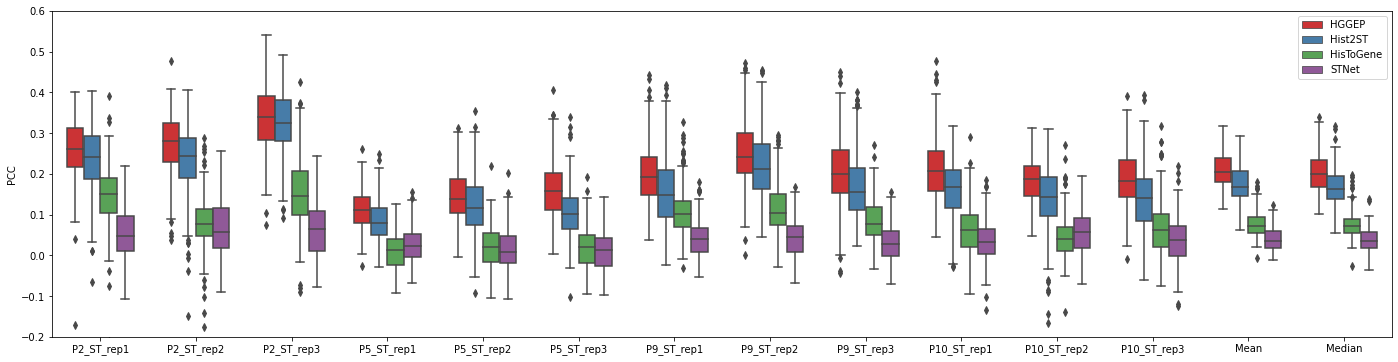

In [22]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

R_HGGEP_with_mean_median = np.load('./Output/HGGEP_CSCC.npy')
R_Hist2ST_with_mean_median = np.load('./Output/Hist2ST_CSCC.npy')
R_HisToGene_with_mean_median = np.load('./Output/HisToGene_CSCC.npy')
R_STNet_with_mean_median = np.load('./Output/STNet_CSCC.npy')

x_label = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3', \
           'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'Mean', 'Median']

df_combined = pd.DataFrame()
# 重复操作32次
for i in range(len(x_label)):
    # 创建 DataFrame，添加分类变量和列名
    df_class_i = pd.DataFrame(np.transpose(np.array([R_HGGEP_with_mean_median[i], R_Hist2ST_with_mean_median[i],\
                                                      R_HisToGene_with_mean_median[i], R_STNet_with_mean_median[i]])),\
                                                      columns=['HGGEP', 'Hist2ST', 'HisToGene', 'STNet'])
    # df_class_i = pd.DataFrame(data_class1, columns=['HGGEP', 'Hist2ST', 'HisToGene'])
    df_class_i['Category'] = x_label[i]  # 使用 f-string 添加不同的后缀数字

    # 将当前 DataFrame 追加到结果 DataFrame
    # df_combined = pd.concat([df_combined, pd.DataFrame([df_class_i])], ignore_index=True)
    
    df_combined = df_combined._append(df_class_i, ignore_index=True)

# print(df_combined)

# 合并两类数据
# df_combined = pd.concat([df_class1, df_class2])
# print(df_combined)

# 将列名融入数据，以便使用`hue`
df_combined_melted = pd.melt(df_combined, id_vars=['Category'], var_name='Column')

# 设置图形大小
plt.figure(figsize=(24, 6))

# 创建箱线图
sns.boxplot(x='Category', y='value', data=df_combined_melted, hue='Column', showfliers=True, width=0.7, palette='Set1')

plt.legend(title='')
# 设置 y 轴上下限
plt.ylim(-0.2, 0.6)


# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 添加标题和标签
# plt.title('Boxplots of Columns by Category')
plt.xlabel('')
plt.ylabel('PCC')

# 显示图形
# plt.show()
plt.savefig('./figures/2_CSCC.pdf')
# plt.savefig('./figures/CSCC.png', dpi=600)

Test her2st all!

In [ ]:
folds=[]
for i in range(32):
    folds.append(i)
print(folds)
data='her2st'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    label=testset.label[testset.names[0]]
    # genes=785
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/her2st_official/'+str(fold)+'-Hist2ST.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    pred, gt = test(model, test_loader,'cuda')
    R=get_R(pred,gt)[0]
    print('Pearson Correlation Mean:',np.nanmean(R))  # 计算一个数组（或矩阵）中的非NaN（非数字）值的平均值。
    print('Pearson Correlation Median:',np.nanmedian(R))

Test cscc all !

In [ ]:
folds=[]
for i in range(12):
    folds.append(i)
# print(folds)
data='cscc'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785

for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)

    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/cSCC_official/'+str(fold)+'_skin'+'-Hist2ST.ckpt'))
    # model.load_state_dict(torch.load(f'./model/Hist2ST_Best_0.3031.ckpt'))
    pred, gt = test(model, test_loader,'cuda')
    R=get_R(pred,gt)[0]
    print('Pearson Correlation Mean:',np.nanmean(R))  # 计算一个数组（或矩阵）中的非NaN（非数字）值的平均值。
    print('Pearson Correlation Median:',np.nanmedian(R))

均值体现模型大概性能，最后还是要画箱线图，取中间值.

Top10 Gene，2个数据集，3个对比模型，直接用柱状图表示，选用我们最优的基因来展示。

In [ ]:
folds=[]
for i in range(12):
    folds.append(i)
# print(folds)
data='cscc'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/skin_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    model.load_state_dict(torch.load(f'./model/cscc/'+str(fold)+'-HGGEP.ckpt'))
    # model.load_state_dict(torch.load(f'./model/cSCC_official/'+str(fold)+'_skin-Hist2ST.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    results_all.append(res)


In [6]:
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=results_all[0].index, columns=results_all[0].columns)

# Print the resulting DataFrame
print(mean_df[:10])

#          -log10_PV       PCC            PV
# EIF5     33.192085  0.411756  1.044396e-11
# MSMO1    29.265893  0.384066  1.515783e-09
# STMN1    27.657350  0.374602  2.118015e-09
# PRDX4    26.203203  0.366622  4.144496e-09
# CASP14   25.330214  0.360725  4.421094e-09
# PPM1G    24.665134  0.355337  1.043308e-08
# NHP2     24.134356  0.351090  1.146501e-08
# KIF5B    23.693612  0.347940  2.586017e-08
# DDX21    23.125779  0.344281  3.031253e-08
# PRPF40A  22.012607  0.337491  3.431676e-08


         -log10_PV       PCC            PV
EIF5     33.192085  0.411756  1.044396e-11
MSMO1    29.265893  0.384066  1.515783e-09
STMN1    27.657350  0.374602  2.118015e-09
PRDX4    26.203203  0.366622  4.144496e-09
CASP14   25.330214  0.360725  4.421094e-09
PPM1G    24.665134  0.355337  1.043308e-08
NHP2     24.134356  0.351090  1.146501e-08
KIF5B    23.693612  0.347940  2.586017e-08
DDX21    23.125779  0.344281  3.031253e-08
PRPF40A  22.012607  0.337491  3.431676e-08


In [9]:
# Hist2ST
from HIST2ST_Baseline import *

folds=[]
for i in range(12):
    folds.append(i)
# print(folds)
data='cscc'
prune='Grid' if data=='her2st' else 'NA'
genes=171 if data=='cscc' else 785
gene_names = list(np.load('data/skin_hvg_cut_1000.npy',allow_pickle=True))

def comp_tsne_km(adata,k=10):
    sc.pp.pca(adata)
    sc.tl.tsne(adata)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit(adata.obsm['X_pca'])
    adata.obs['kmeans'] = kmeans.labels_.astype(str)
    return adata

def get_PCC(adata_pre, adata_true):
    # 提取 var_names 列的基因名称
    gene_names = adata_pre.columns

    # 初始化一个空的 DataFrame 用于存储结果
    result_df = pd.DataFrame(index=['-log10_PV', 'PCC', 'PV',], columns=gene_names)

    # 计算每一列的皮尔逊相关系数和 p-value
    for gene in gene_names:
        corr_coef, p_value = pearsonr(adata_pre[gene], adata_true[gene])
        result_df[gene] = [-np.log10(p_value), corr_coef, p_value]

    # 转置 DataFrame，使得基因名称成为索引
    result_df = result_df.T

    # 根据 PCC 指数排序
    result_df_sorted = result_df.sort_values(by='-log10_PV', ascending=False)

    return result_df_sorted

CSCC_results_all = []
for fold in folds:
    testset = pk_load(fold,'test',dataset=data,flatten=False,adj=True,ori=True,prune=prune)
    test_loader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)
    model=Hist2ST(
        depth1=d1, depth2=d2,depth3=d3,n_genes=genes, 
        kernel_size=k, patch_size=p,
        heads=h, channel=c, dropout=0.2,
        zinb=0.25, nb=False,
        bake=5, lamb=0.5,
    )
    # model.load_state_dict(torch.load(f'./model/cscc/'+str(fold)+'-HGGEP.ckpt'))
    model.load_state_dict(torch.load(f'./model/cSCC_official/'+str(fold)+'_skin-Hist2ST.ckpt'))
    adata_pred, adata_truth = test(model, test_loader)

    adata_pred = comp_tsne_km(adata_pred,4)
    sc.pp.scale(adata_pred)
    sc.pp.scale(adata_truth)
    adata_pred.var_names = gene_names
    adata_truth.var_names = gene_names
    adata_true = pd.DataFrame(data=adata_truth.X, index=adata_truth.obs_names, columns=adata_truth.var_names)
    adata_pre = pd.DataFrame(data=adata_pred.X, index=adata_pred.obs_names, columns=adata_pred.var_names)
    res = get_PCC(adata_pre, adata_true)
    # print(res)
    CSCC_results_all.append(res)


te_names: ['P2_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


te_names: ['P2_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


te_names: ['P2_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


te_names: ['P5_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


te_names: ['P5_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


te_names: ['P5_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


te_names: ['P9_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


te_names: ['P9_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


te_names: ['P9_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


te_names: ['P10_ST_rep1']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


te_names: ['P10_ST_rep2']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


te_names: ['P10_ST_rep3']
Loading imgs...
Loading metadata...


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


In [11]:
# 计算对应的基因的表达量 ： Hist2ST
# Calculate the mean across all DataFrames element-wise
mean_df = np.mean([df.values for df in CSCC_results_all], axis=0)

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_df, index=CSCC_results_all[0].index, columns=CSCC_results_all[0].columns)
print(mean_df[:10])
# Print the resulting DataFrame
for gene in ['EIF5', 'MSMO1', 'STMN1', 'PRDX4', 'CASP14', 'PPM1G', 'NHP2', 'KIF5B', 'DDX21', 'PRPF40A']:
    print(mean_df.loc[gene])

        -log10_PV       PCC            PV
ITGA6   27.445375  0.377728  8.647593e-11
CASP14  25.413297  0.360547  8.350950e-10
PMEPA1  24.000534  0.348059  1.073011e-08
MTDH    22.823049  0.340545  1.363215e-08
MSMO1   21.324091  0.326542  9.597731e-08
KIF5B   20.864708  0.323087  1.094107e-07
PSMA7   20.309960  0.318816  1.400973e-07
SPINK5  19.784245  0.313636  4.717253e-07
PRDX4   19.471548  0.311021  5.167994e-07
PI3     19.089026  0.307141  1.700073e-06
-log10_PV    18.165481
PCC           0.300335
PV            0.000003
Name: EIF5, dtype: float64
-log10_PV    2.132409e+01
PCC          3.265417e-01
PV           9.597731e-08
Name: MSMO1, dtype: float64
-log10_PV    12.164074
PCC           0.244271
PV            0.000150
Name: STMN1, dtype: float64
-log10_PV    1.947155e+01
PCC          3.110205e-01
PV           5.167994e-07
Name: PRDX4, dtype: float64
-log10_PV    2.541330e+01
PCC          3.605468e-01
PV           8.350950e-10
Name: CASP14, dtype: float64
-log10_PV    7.154755
PCC 

# Figure 4 Performance comparison of top 10 gene predictions at cSCC datasets

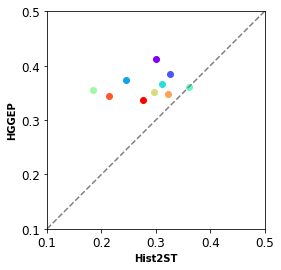

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['EIF5', 'MSMO1', 'STMN1', 'PRDX4', 'CASP14', 'PPM1G', 'NHP2', 'KIF5B', 'DDX21', 'PRPF40A']
# hist2st_data = np.random.rand(10)  # 替换为Hist2ST模型的PCC数据
hist2st_data = [0.300335, 3.265417e-01, 0.244271, 3.110205e-01, 3.605468e-01, 0.185025, 0.297573, 3.230871e-01, 0.214541, 0.277182]
hggep_data = [ 0.411756, 0.384066, 0.374602, 0.366622, 0.360725, 0.355337, 0.351090, 0.347940, 0.344281, 0.337491]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    plt.scatter(hist2st_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('Hist2ST', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.1, 0.5)
plt.ylim(0.1, 0.5)

# 设置刻度线
plt.xticks(np.linspace(0.1, 0.5, 5))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.1, 0.5, 5))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 保存高清图像
plt.savefig('./figures/4_4.pdf')

# 显示图表
plt.show()


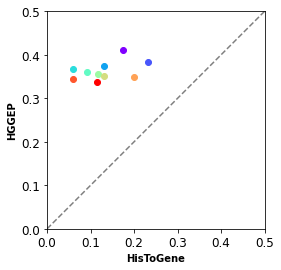

In [28]:
# HisToGene

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['EIF5', 'MSMO1', 'STMN1', 'PRDX4', 'CASP14', 'PPM1G', 'NHP2', 'KIF5B', 'DDX21', 'PRPF40A']
# hist2st_data = np.random.rand(10)  # 替换为Hist2ST模型的PCC数据
hist2st_data = [0.175290, 0.231041, 0.130781, 0.059450, 0.092114, 0.118048, 0.131355, 0.200790, 0.059416, 0.115046]
hggep_data = [ 0.411756, 0.384066, 0.374602, 0.366622, 0.360725, 0.355337, 0.351090, 0.347940, 0.344281, 0.337491]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    plt.scatter(hist2st_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('HisToGene', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
# plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.0, 0.5)
plt.ylim(0.0, 0.5)

# 设置刻度线
plt.xticks(np.linspace(0.0, 0.5, 6))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.0, 0.5, 6))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('./figures/4_3.pdf')

# 显示图表
plt.show()

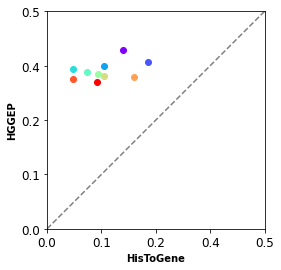

In [52]:
# HisToGene

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

# 模拟数据，实际应替换为您的数据
genes = ['EIF5', 'MSMO1', 'STMN1', 'PRDX4', 'CASP14', 'PPM1G', 'NHP2', 'KIF5B', 'DDX21', 'PRPF40A']
# hist2st_data = np.random.rand(10)  # 替换为Hist2ST模型的PCC数据
hist2st_data = [0.175290, 0.231041, 0.130781, 0.059450, 0.092114, 0.118048, 0.131355, 0.200790, 0.059416, 0.115046]
hggep_data = [ 0.411756, 0.384066, 0.374602, 0.366622, 0.360725, 0.355337, 0.351090, 0.347940, 0.344281, 0.337491]   # 替换为HGGEP模型的PCC数据

# 为每个基因生成不同的颜色
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

# 绘制散点图
for i in range(10):
    plt.scatter(hist2st_data[i], hggep_data[i], label=genes[i], color=colors[i])

# 添加标签和标题
plt.xlabel('HisToGene', fontweight='bold')
plt.ylabel('HGGEP', fontweight='bold')
# plt.title('')

# 绘制对角虚线
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', transform=plt.gca().transAxes)

# 统一注释放在图外，并附带颜色小点
# for i, gene in enumerate(genes):
    # # plt.figtext(1.05, 0.92 - i * 0.04, f"{gene}", color=colors[i], ha='left', fontsize=10)
    # plt.scatter(0.4, 0.91 - i * 0.1, color=colors[i], s=30, marker='o')


# 设置坐标轴纵横比例相等
plt.gca().set_aspect('equal', adjustable='box')

# 设置图形背景为白色
plt.gcf().set_facecolor('white')

# 设置横纵轴的阈值范围为1
plt.xlim(0.0, 0.5)
plt.ylim(0.0, 0.5)

# 设置刻度线
plt.xticks(np.linspace(0.0, 0.5, 5))  # 在横轴上设置刻度线
plt.yticks(np.linspace(0.0, 0.5, 5))  # 在纵轴上设置刻度线

# 设置刻度线，并保留两位小数
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# 设置刻度值字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 保存高清图像
plt.savefig('./Output/comparison_plot.png', dpi=600)

# 显示图表
plt.show()

# 整合所有模型的值
# HGGEP

          -log10_PV       PCC            PV
 EIF5     33.192085  0.411756  1.044396e-11
 MSMO1    29.265893  0.384066  1.515783e-09
 STMN1    27.657350  0.374602  2.118015e-09
 PRDX4    26.203203  0.366622  4.144496e-09
 CASP14   25.330214  0.360725  4.421094e-09
 PPM1G    24.665134  0.355337  1.043308e-08
 NHP2     24.134356  0.351090  1.146501e-08
 KIF5B    23.693612  0.347940  2.586017e-08
 DDX21    23.125779  0.344281  3.031253e-08
 PRPF40A  22.012607  0.337491  3.431676e-08


# HisToGene
        -log10_PV       PCC        PV
NEFL    15.215788  0.262868  0.000610
MSMO1   13.084469  0.231041  0.001423
PI3     11.509860  0.216406  0.001552
SPRR2D  10.548399  0.210994  0.002019
FDFT1    9.611303  0.193588  0.002579
ANXA1    8.874972  0.192113  0.003192
KIF5B    8.398426  0.200790  0.004157
EIF5     7.601206  0.175290  0.005606
IGFL1    7.293440  0.185138  0.006195
RALA     7.032634  0.181865  0.006496


# Hist2ST
        -log10_PV       PCC            PV
ITGA6   27.445375  0.377728  8.647593e-11
CASP14  25.413297  0.360547  8.350950e-10
PMEPA1  24.000534  0.348059  1.073011e-08
MTDH    22.823049  0.340545  1.363215e-08
MSMO1   21.324091  0.326542  9.597731e-08
KIF5B   20.864708  0.323087  1.094107e-07
PSMA7   20.309960  0.318816  1.400973e-07
SPINK5  19.784245  0.313636  4.717253e-07
PRDX4   19.471548  0.311021  5.167994e-07
PI3     19.089026  0.307141  1.700073e-06